# Loading Data

In [5]:
import pandas as pd
import re 
import json

In [4]:
csv_file = "../../data/raw/discharge_sample.csv"

df = pd.read_csv(csv_file, nrows=50)

print(df.shape)
print(df.dtypes)

(50, 8)
note_id       object
subject_id     int64
hadm_id        int64
note_type     object
note_seq       int64
charttime     object
storetime     object
text          object
dtype: object


In [7]:
data_file = "../../data/processed/csv/discharge_data_50_rows.csv"
df.to_csv(data_file)

In [8]:
data_frame = pd.read_csv(data_file)
print(data_frame.shape)

(50, 9)


# process the data

In [9]:
def clean_text(text):
    # Convert to string, remove newlines/spaces
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    # Remove placeholder underscores if present
    text = text.replace("___", "")
    return text.strip()

data_frame["clean_text"] = data_frame["text"].apply(clean_text)

In [13]:

# Filter for cardiac-related notes
# Comment out this section if you want all discharge notes
# cardiac_keywords = ["cardiac", "heart", "myocardial", "coronary", "ECG", "heart failure"]
# df = df[df["clean_text"].str.contains("|".join(cardiac_keywords), case=False, na=False)]
# print("After cardiac filter:", df.shape)

# Chunk the text (e.g., every 200 words)
def chunk_text_with_overlap(text, chunk_size=250, overlap=50):
    words = text.split()
    for i in range(0, len(words), chunk_size - overlap):
        yield " ".join(words[i : i + chunk_size])

documents = []
for _, row in data_frame.iterrows():
    note_text = row["clean_text"]
    # Create chunks for each row
    for idx, chunk in enumerate(chunk_text_with_overlap(note_text, chunk_size=250)):
        doc = {
            "note_id": row["note_id"],
            "subject_id": row["subject_id"],
            "hadm_id": row["hadm_id"],
            "note_type": row["note_type"],
            "note_seq": row["note_seq"],
            "charttime": row["charttime"],
            "storetime": row["storetime"],
            "chunk_index": idx,
            "chunk_text": chunk
        }
        documents.append(doc)

# convert and save in JSON format

In [14]:
# Save the chunked documents to JSON
output_path = "../../data/processed/json/processed_data_50r.json"
with open(output_path, "w") as f:
    json.dump(documents, f, indent=2)

print(f"Saved {len(documents)} chunked documents to {output_path}")

Saved 388 chunked documents to ../../data/processed/json/processed_data_50r.json


# Evaluations

In [15]:
import json
import re
from sklearn.metrics import f1_score
import pandas as pd

# Utility functions
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# Load responses.json
with open('../../data/evaluation/eval_result/model_results_r50.json', 'r') as f:
    data = json.load(f)

results = []

# Evaluate each item
for item in data:
    q = item['query']
    pred = item['gemini_answer']
    true = item['original_answer']
    
    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)
    
    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3)
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display average scores
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()

print("\nEvaluation Results")
print("-------------------")
print(df[['question', 'exact_match', 'f1_score']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

# Save to CSV (optional)
df.to_csv("evaluation_results.csv", index=False)
print("\nSaved detailed results to evaluation_results.csv")


Evaluation Results
-------------------
                                             question  exact_match  f1_score
0      What is the patient's MELD score on admission?            0     0.500
1   Which medication was discontinued due to high ...            0     0.000
2   What procedure was performed to remove fluid f...            0     0.000
3   What is the furosemide dosage prescribed on di...            0     0.231
4   Was the patient scheduled for outpatient parac...            0     0.000
5   What dietary instructions were given on discha...            0     0.039
6          What is the patient's discharge diagnosis?            0     0.000
7   What were the lab values for serum sodium on a...            0     0.074
8   Which medications were prescribed for hepatic ...            0     0.231
9    What was the reason for performing paracentesis?            0     0.303
10       What were the initial vital signs in the ED?            0     0.074
11  What are the key elements of the

In [16]:
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# New helper: is ground truth in sources?
def is_answer_in_sources(answer, sources):
    normalized_answer = normalize(answer)
    for doc in sources:
        if normalized_answer in normalize(doc):
            return True
    return False

# New helper: check for abstention
def is_abstaining(pred):
    pred = normalize(pred)
    return any(x in pred for x in ["not available", "insufficient", "no information", "unknown", "not provided"])

# Load responses.json
with open('../../data/evaluation/eval_result/model_results_r50.json', 'r') as f:
    data = json.load(f)

results = []

# Evaluate each item
for item in data:
    q = item['query']
    pred = item['gemini_answer']
    true = item['original_answer']
    sources = item['source_documents']

    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)

    # New logic
    answer_present = is_answer_in_sources(true, sources)
    abstained = is_abstaining(pred)
    correct_abstention = int(abstained and not answer_present)
    hallucinated = int(abstained and answer_present)

    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3),
        "abstained": abstained,
        "correct_abstention": correct_abstention,
        "hallucinated": hallucinated
    })

# Create DataFrame
df = pd.DataFrame(results)

# Summary
avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()
correct_abstention_rate = df['correct_abstention'].mean()
hallucination_rate = df['hallucinated'].mean()

# Filter out correct abstentions with zero F1 (they didn't try to answer)
filtered_df = df[~((df['f1_score'] == 0.0) & (df['correct_abstention'] == 1))]

# Adjusted F1 (only for attempted answers or failed attempts that were not abstentions)
adjusted_f1 = filtered_df['f1_score'].mean()

print(f"\nAdjusted F1 Score (excluding correct abstentions): {adjusted_f1:.2f}")

print("\nEvaluation Results")
print("-------------------")
print(df[['question', 'exact_match', 'f1_score', 'correct_abstention', 'hallucinated']])
print(f"\nAverage Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")
print(f"Correct Abstention Rate: {correct_abstention_rate:.2f}")
print(f"Hallucination Rate: {hallucination_rate:.2f}")

df.to_csv("evaluation_with_abstention_analysis.csv", index=False)
print("\nSaved results to evaluation_with_abstention_analysis.csv")



Adjusted F1 Score (excluding correct abstentions): 0.13

Evaluation Results
-------------------
                                             question  exact_match  f1_score  \
0      What is the patient's MELD score on admission?            0     0.500   
1   Which medication was discontinued due to high ...            0     0.000   
2   What procedure was performed to remove fluid f...            0     0.000   
3   What is the furosemide dosage prescribed on di...            0     0.231   
4   Was the patient scheduled for outpatient parac...            0     0.000   
5   What dietary instructions were given on discha...            0     0.039   
6          What is the patient's discharge diagnosis?            0     0.000   
7   What were the lab values for serum sodium on a...            0     0.074   
8   Which medications were prescribed for hepatic ...            0     0.231   
9    What was the reason for performing paracentesis?            0     0.303   
10       What were the 

In [17]:
import json
import re
import pandas as pd
from rouge_score import rouge_scorer

# -------------------------------
# Utility Functions
# -------------------------------

def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

def exact_match(pred, true):
    return int(normalize(pred) == normalize(true))

def f1_score_single(pred, true):
    pred_tokens = set(normalize(pred).split())
    true_tokens = set(normalize(true).split())
    common = pred_tokens & true_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

def is_abstaining(pred):
    pred = normalize(pred)
    return any(x in pred for x in ["not available", "insufficient", "no information", "unknown", "not provided"])

# Initialize ROUGE scorer globally
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Soft-matching based grounding checker
def is_answer_in_sources(answer, sources, threshold=0.5):
    for doc in sources:
        score = scorer.score(answer, doc)['rougeL'].fmeasure
        if score >= threshold:
            return True
    return False

# -------------------------------
# Load Data
# -------------------------------

with open('../../data/evaluation/eval_result/model_results_r50.json', 'r') as f:
    data = json.load(f)

results = []

# -------------------------------
# Evaluate Each Record
# -------------------------------

for item in data:
    q = item['query']
    pred = item['gemini_answer']
    true = item['original_answer']
    sources = item['source_documents']

    em = exact_match(pred, true)
    f1 = f1_score_single(pred, true)
    rougeL = scorer.score(pred, true)['rougeL'].fmeasure

    abstained = is_abstaining(pred)
    answer_present = is_answer_in_sources(true, sources, threshold=0.5)
    correct_abstention = int(abstained and not answer_present)
    hallucinated = int(abstained and answer_present)

    results.append({
        "question": q,
        "ground_truth": true,
        "model_answer": pred,
        "exact_match": em,
        "f1_score": round(f1, 3),
        "rougeL": round(rougeL, 3),
        "correct_abstention": correct_abstention,
        "hallucinated": hallucinated
    })

# -------------------------------
# Reporting
# -------------------------------

df = pd.DataFrame(results)

avg_em = df['exact_match'].mean()
avg_f1 = df['f1_score'].mean()
avg_rougeL = df['rougeL'].mean()
correct_abstention_rate = df['correct_abstention'].mean()
hallucination_rate = df['hallucinated'].mean()

# Filter for Adjusted F1
filtered_df = df[~((df['f1_score'] == 0.0) & (df['correct_abstention'] == 1))]
adjusted_f1 = filtered_df['f1_score'].mean()

# Print summary
print(f"\nAdjusted F1 Score (excluding correct abstentions): {adjusted_f1:.2f}")
print("\nROUGE-L Evaluation")
print("-------------------")
print(df[['question', 'rougeL']])
print(f"\nAverage ROUGE-L Score: {avg_rougeL:.2f}")
print(f"Average Exact Match: {avg_em:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")
print(f"Correct Abstention Rate: {correct_abstention_rate:.2f}")
print(f"Hallucination Rate: {hallucination_rate:.2f}")

# -------------------------------
# Save to CSV
# -------------------------------
df.to_csv("evaluation_with_rougeL.csv", index=False)
print("\nSaved results to evaluation_with_rougeL.csv")



Adjusted F1 Score (excluding correct abstentions): 0.13

ROUGE-L Evaluation
-------------------
                                             question  rougeL
0      What is the patient's MELD score on admission?   0.462
1   Which medication was discontinued due to high ...   0.000
2   What procedure was performed to remove fluid f...   0.043
3   What is the furosemide dosage prescribed on di...   0.267
4   Was the patient scheduled for outpatient parac...   0.057
5   What dietary instructions were given on discha...   0.032
6          What is the patient's discharge diagnosis?   0.000
7   What were the lab values for serum sodium on a...   0.037
8   Which medications were prescribed for hepatic ...   0.194
9    What was the reason for performing paracentesis?   0.263
10       What were the initial vital signs in the ED?   0.079
11  What are the key elements of the patient's pas...   0.054
12  What did the patient report about her medicati...   0.186
13     What imaging studies were pe

In [18]:
import json
import re
import pandas as pd
from bert_score import score as bert_score

# -------------------------------
# Utility Function
# -------------------------------

def normalize(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

# -------------------------------
# Load Your JSON Data
# -------------------------------

with open('../../data/evaluation/eval_result/model_results_r50.json', 'r') as f:
    data = json.load(f)

# -------------------------------
# Extract Predictions and References
# -------------------------------

preds = [normalize(item['gemini_answer']) for item in data]
refs = [normalize(item['original_answer']) for item in data]

# -------------------------------
# Compute BERTScore
# -------------------------------

P, R, F1 = bert_score(preds, refs, lang="en", verbose=True)

# -------------------------------
# Assemble Results
# -------------------------------

bert_results = [{
    "question": item['query'],
    "ground_truth": refs[i],
    "model_answer": preds[i],
    "bert_precision": round(P[i].item(), 3),
    "bert_recall": round(R[i].item(), 3),
    "bert_f1": round(F1[i].item(), 3)
} for i, item in enumerate(data)]

# -------------------------------
# Create DataFrame
# -------------------------------

df_bert = pd.DataFrame(bert_results)

# -------------------------------
# Display Summary
# -------------------------------

avg_bert_f1 = df_bert['bert_f1'].mean()
avg_bert_p = df_bert['bert_precision'].mean()
avg_bert_r = df_bert['bert_recall'].mean()

print("\nBERTScore Evaluation")
print("---------------------")
print(df_bert[['question', 'bert_f1']])
print(f"\nAverage BERT Precision: {avg_bert_p:.2f}")
print(f"Average BERT Recall:    {avg_bert_r:.2f}")
print(f"Average BERT F1 Score:  {avg_bert_f1:.2f}")

# -------------------------------
# Save to CSV
# -------------------------------

df_bert.to_csv("evaluation_with_bertscore.csv", index=False)
print("\nSaved results to evaluation_with_bertscore.csv")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 22.10 seconds, 0.91 sentences/sec

BERTScore Evaluation
---------------------
                                             question  bert_f1
0      What is the patient's MELD score on admission?    0.851
1   Which medication was discontinued due to high ...    0.761
2   What procedure was performed to remove fluid f...    0.847
3   What is the furosemide dosage prescribed on di...    0.839
4   Was the patient scheduled for outpatient parac...    0.790
5   What dietary instructions were given on discha...    0.827
6          What is the patient's discharge diagnosis?    0.805
7   What were the lab values for serum sodium on a...    0.781
8   Which medications were prescribed for hepatic ...    0.854
9    What was the reason for performing paracentesis?    0.876
10       What were the initial vital signs in the ED?    0.798
11  What are the key elements of the patient's pas...    0.807
12  What did the patient report about her medicati...    0.850
13     What imaging studies were

# Visualization

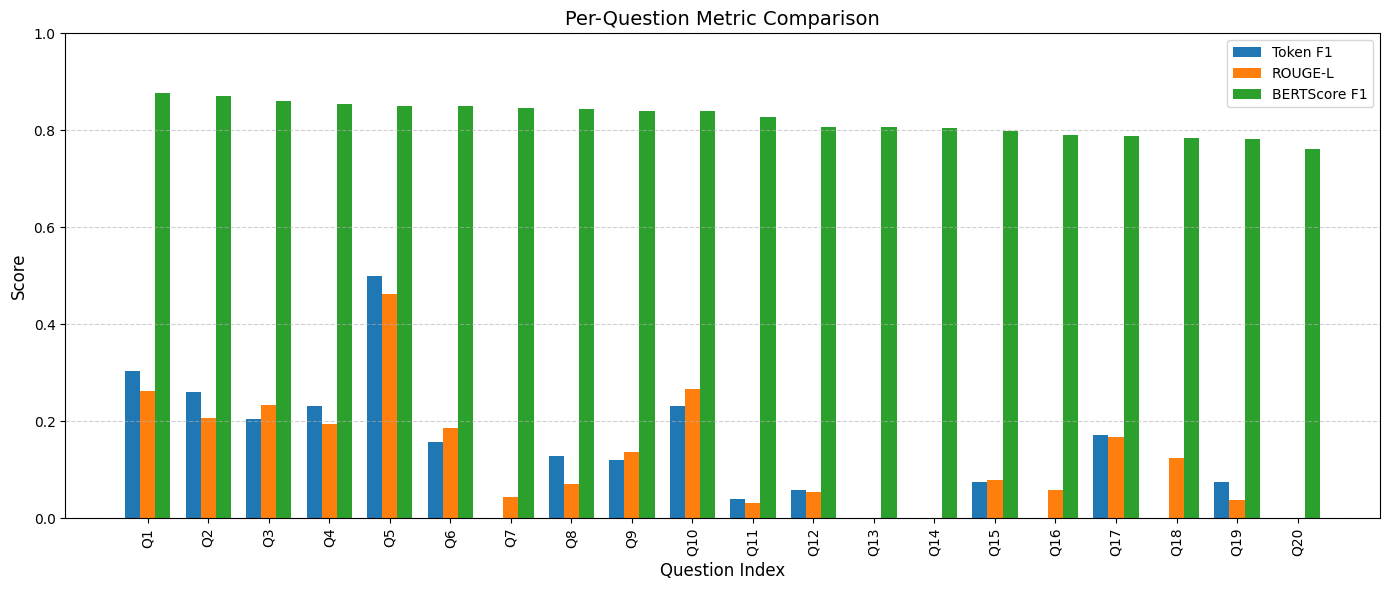

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Load Evaluation Files
# -------------------------------

bert_df = pd.read_csv("evaluation_with_bertscore.csv")
rouge_df = pd.read_csv("evaluation_with_rougeL.csv")

# If all metrics are in one file, just use:
# df = pd.read_csv("evaluation_combined.csv")

# -------------------------------
# Merge on Question if needed
# -------------------------------

df = pd.merge(bert_df[['question', 'bert_f1']], 
              rouge_df[['question', 'f1_score', 'rougeL']], 
              on='question', 
              how='inner')

# -------------------------------
# Sort for Clean View (optional)
# -------------------------------

df = df.sort_values(by='bert_f1', ascending=False)

# -------------------------------
# Plot: Metric Comparison Per Question
# -------------------------------

plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(df))

plt.bar([i - bar_width for i in x], df['f1_score'], width=bar_width, label='Token F1')
plt.bar(x, df['rougeL'], width=bar_width, label='ROUGE-L')
plt.bar([i + bar_width for i in x], df['bert_f1'], width=bar_width, label='BERTScore F1')

plt.xlabel("Question Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Per-Question Metric Comparison", fontsize=14)
plt.xticks(ticks=x, labels=[f"Q{i+1}" for i in x], rotation=90)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Per-Question Metric Comparison

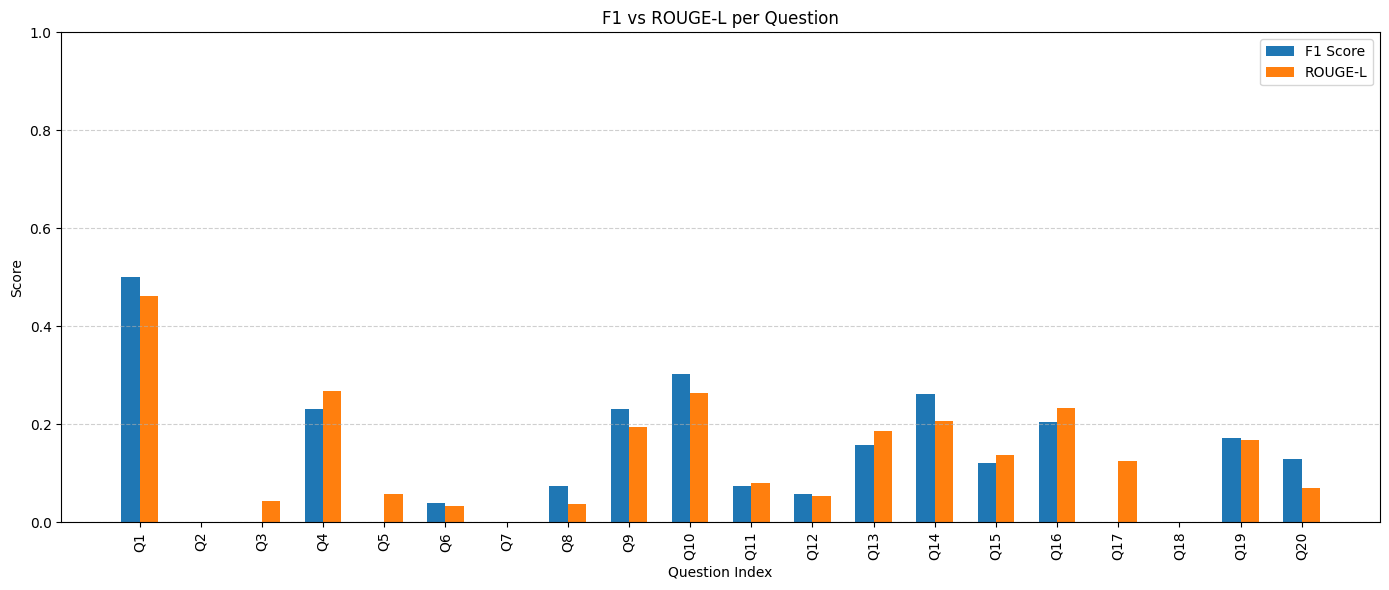

In [6]:
df = pd.read_csv("evaluation_with_rougeL.csv")

plt.figure(figsize=(14, 6))
bar_width = 0.3
x = range(len(df))

plt.bar([i - bar_width/2 for i in x], df['f1_score'], width=bar_width, label='F1 Score')
plt.bar([i + bar_width/2 for i in x], df['rougeL'], width=bar_width, label='ROUGE-L')

plt.xlabel("Question Index")
plt.ylabel("Score")
plt.title("F1 vs ROUGE-L per Question")
plt.xticks(ticks=x, labels=[f"Q{i+1}" for i in x], rotation=90)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_240287/1018041035.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Metric', y='Score', palette="Set2")


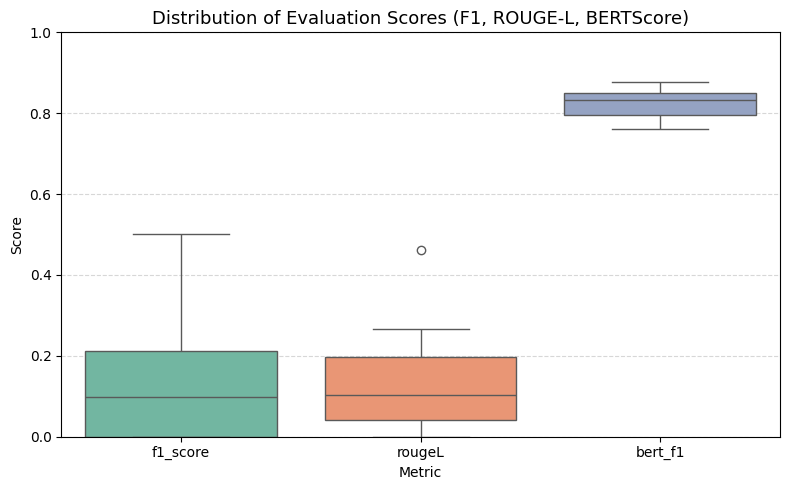

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# Load Evaluation Results
# -------------------------------

# Load token-level and ROUGE metrics
rouge_df = pd.read_csv("evaluation_with_rougeL.csv")

# Load semantic similarity (BERTScore)
bert_df = pd.read_csv("evaluation_with_bertscore.csv")

# -------------------------------
# Merge on Question
# -------------------------------

df = pd.merge(
    rouge_df[['question', 'f1_score', 'rougeL']],
    bert_df[['question', 'bert_f1']],
    on='question',
    how='inner'
)

# -------------------------------
# Create Boxplot of Score Distributions
# -------------------------------

# Convert to long format for seaborn
plot_df = df[['f1_score', 'rougeL', 'bert_f1']].melt(var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=plot_df, x='Metric', y='Score', palette="Set2")
plt.title("Distribution of Evaluation Scores (F1, ROUGE-L, BERTScore)", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


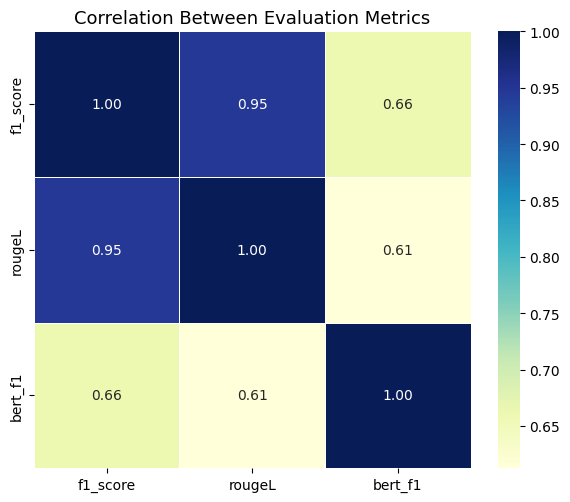

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# Load Evaluation Results
# -------------------------------

# Load both evaluation files
rouge_df = pd.read_csv("evaluation_with_rougeL.csv")
bert_df = pd.read_csv("evaluation_with_bertscore.csv")

# Merge them on 'question'
df = pd.merge(
    rouge_df[['question', 'f1_score', 'rougeL']],
    bert_df[['question', 'bert_f1']],
    on='question',
    how='inner'
)

# -------------------------------
# Plot Correlation Heatmap
# -------------------------------

plt.figure(figsize=(6, 5))
correlation = df[['f1_score', 'rougeL', 'bert_f1']].corr()

sns.heatmap(correlation, annot=True, cmap="YlGnBu", square=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Evaluation Metrics", fontsize=13)
plt.tight_layout()
plt.show()


In [12]:
from graphviz import Digraph

# Create a left-to-right flow graph
dot = Digraph(comment='RAG Pipeline Architecture')
dot.attr(rankdir='LR', size='12,6')
dot.attr('node', shape='box', style='filled', fillcolor='lightgray', fontname='Helvetica', fontsize='10')

# Data Layer
dot.node('A1', 'Raw Discharge\nSummaries\n(JSON: 50 samples)')
dot.node('A2', 'Chunking\n+ Preprocessing')
dot.node('A3', 'SentenceTransformer\n(BAAI/bge-base-en-v1.5)')
dot.node('A4', 'FAISS Index\n+ Metadata Store')

# Retrieval Layer
dot.node('B1', 'FAISSRetriever\n(similarity threshold)')
dot.node('B2', 'Top-k Document\nRetrieval')

# Compression Layer
dot.node('C1', 'LLMChainExtractor\n(OpenAI LLM + PromptTemplate)')
dot.node('C2', 'Chain-of-Thought\nContext Compression')

# Answer Generation Layer
dot.node('D1', 'LLM: Gemini 2.0 Flash')
dot.node('D2', 'Initial QA Pass\n(Per Document)')
dot.node('D3', 'Filter Irrelevant Answers\n(“Not available”)')
dot.node('D4', 'Final Prompt\n+ Answer')

# Connect nodes
dot.edge('A1', 'A2')
dot.edge('A2', 'A3')
dot.edge('A3', 'A4')
dot.edge('A4', 'B1')
dot.edge('B1', 'B2')
dot.edge('B2', 'C1')
dot.edge('C1', 'C2')
dot.edge('C2', 'D1')
dot.edge('D1', 'D2')
dot.edge('D2', 'D3')
dot.edge('D3', 'D4')

# Render in notebook
dot.render('rag_pipeline_diagram', format='png', cleanup=True)
dot


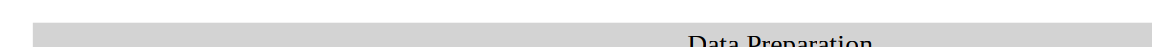

In [6]:
from graphviz import Digraph

# Create a new Digraph for the RAG Pipeline with higher resolution
dot = Digraph('RAG_Pipeline', comment='RAG Pipeline Architecture')
dot.attr(rankdir='LR', size='16,10', splines='ortho', dpi='300')
dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue', fontname='Helvetica', fontsize='12')

# Cluster 1: Data Preparation
with dot.subgraph(name='cluster_data') as c:
    c.attr(label='Data Preparation', style='filled', color='lightgrey')
    c.node('Data1', 'Raw Discharge Summaries\n(JSON: 50 rows)')
    c.node('Data2', 'Chunking & Preprocessing')
    c.node('Data3', 'Embedding\n(BAAI/bge-base-en-v1.5)')
    c.node('Data4', 'FAISS Index\n+ Metadata Store')
    c.attr(rank='same')

# Cluster 2: Retrieval
with dot.subgraph(name='cluster_retrieval') as c:
    c.attr(label='Retrieval', style='filled', color='lightgrey')
    c.node('Ret1', 'FAISSRetriever\n(similarity threshold=0.35)')
    c.node('Ret2', 'Top-k Document Retrieval')
    c.attr(rank='same')

# Cluster 3: Compression
with dot.subgraph(name='cluster_compression') as c:
    c.attr(label='Compression', style='filled', color='lightgrey')
    c.node('Comp1', 'LLMChainExtractor\n(OpenAI + PromptTemplate)')
    c.node('Comp2', 'Chain-of-Thought\nContext Compression')
    c.attr(rank='same')

# Cluster 4: QA Generation
with dot.subgraph(name='cluster_qa') as c:
    c.attr(label='QA Generation', style='filled', color='lightgrey')
    c.node('QA1', 'LLM: Gemini 2.0 Flash')
    c.node('QA2', 'Per-Document QA\n(process_docs_individually)')
    c.node('QA3', 'Filter Irrelevant Outputs\n("Not available" removal)')
    c.node('QA4', 'Final Prompt & Answer')
    c.attr(rank='same')

# Connecting nodes across clusters
dot.edge('Data1', 'Data2')
dot.edge('Data2', 'Data3')
dot.edge('Data3', 'Data4')
dot.edge('Data4', 'Ret1')
dot.edge('Ret1', 'Ret2')
dot.edge('Ret2', 'Comp1')
dot.edge('Comp1', 'Comp2')
dot.edge('Comp2', 'QA1')
dot.edge('QA1', 'QA2')
dot.edge('QA2', 'QA3')
dot.edge('QA3', 'QA4')

# Render the diagram (this will create a file "rag_pipeline_adaptive.png" in your current directory)
dot.render('rag_pipeline_adaptive', format='png', cleanup=True)
dot


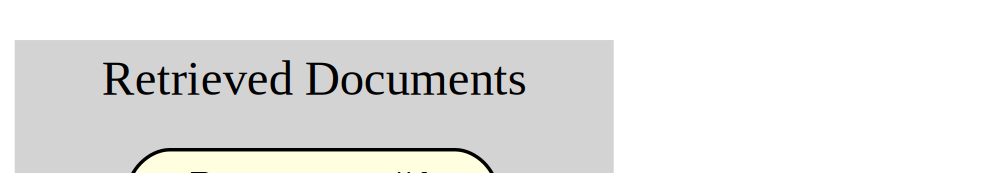

In [7]:
from graphviz import Digraph

# Create a new Digraph for the CoT compression flow
dot = Digraph('CoT_Compression', comment='Chain-of-Thought Compression Flow')
dot.attr(rankdir='LR', size='14,8', splines='ortho', dpi='300')
dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightyellow', fontname='Helvetica', fontsize='12')

# ---------------------
# Cluster: Retrieved Documents
# ---------------------
with dot.subgraph(name='cluster_docs') as c:
    c.attr(label='Retrieved Documents', style='filled', color='lightgrey')
    c.node('Doc1', 'Document #1\n(Chunked Text)')
    c.node('Doc2', 'Document #2\n(Chunked Text)')
    c.node('Doc3', 'Document #3\n(Chunked Text)')
    c.attr(rank='same')

# Node: Concatenate or Aggregate Step
dot.node('Concat', 'Combine/Concat\nRetrieved Chunks')

# Node: CoT Prompt + LLMChainExtractor
dot.node('CoT', 'Chain-of-Thought\nPrompt + LLMChainExtractor')

# Node: Compressed Context
dot.node('Compressed', 'Refined Clinical Context\n(Extracted Facts)')

# Node: Final QA (Optional)
dot.node('FinalQA', 'Answer Generation\n(Downstream Module)')

# Edges: Show the flow
dot.edge('Doc1', 'Concat')
dot.edge('Doc2', 'Concat')
dot.edge('Doc3', 'Concat')
dot.edge('Concat', 'CoT', label='CoT Prompt\n(Clinical Focus)')
dot.edge('CoT', 'Compressed', label='Compression\nProcess')
dot.edge('Compressed', 'FinalQA', label='Used in\nFinal QA')

# Render the diagram (will produce a file "cot_compression_flow_diagram.png")
dot.render('cot_compression_flow_diagram', format='png', cleanup=True)
dot


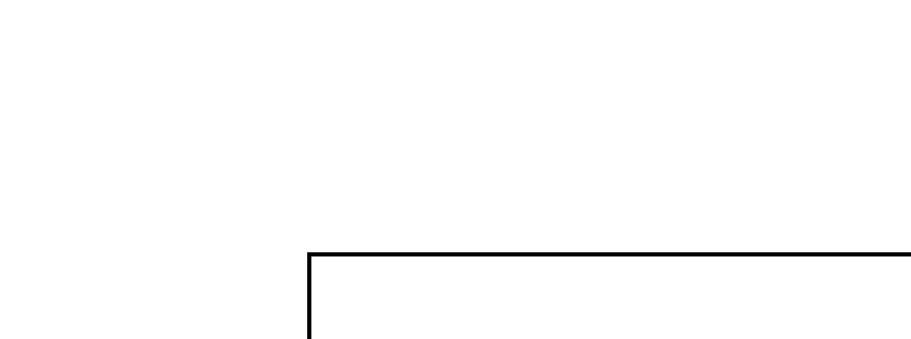

In [8]:
from graphviz import Digraph

dot = Digraph('Evaluation_Pipeline_Updated', comment='Updated Evaluation Pipeline Diagram')
dot.attr(rankdir='TB', size='16,12', splines='ortho', dpi='300')
dot.attr(overlap='false', nodesep='0.8', ranksep='1')
dot.attr('node', shape='box', style='filled,rounded', fontname='Helvetica', fontsize='14')

# Cluster for Input Answers
with dot.subgraph(name='cluster_inputs') as c:
    c.attr(label='Inputs', style='filled', color='lightgrey', fillcolor='whitesmoke')
    c.node('GA', 'Generated Answer', fillcolor='dodgerblue2')
    c.node('GT', 'Ground Truth Answer', fillcolor='dodgerblue2')
    c.attr(rank='same')

# Cluster for Evaluation Metrics
with dot.subgraph(name='cluster_metrics') as m:
    m.attr(label='Evaluation Metrics', style='filled', color='lightgrey', fillcolor='mintcream')
    m.node('F1', 'Token-Level F1 & ROUGE-L', fillcolor='palegreen')
    m.node('BERT', 'BERTScore\n(Semantic Similarity)', fillcolor='palegreen')
    m.node('RET', 'Retrieval Accuracy\n(Top-k Match)', fillcolor='palegreen')
    m.node('HA', 'Hallucination/\nAbstention Analysis', fillcolor='palegreen')
    m.attr(rank='same')

# Cluster for Final Report
with dot.subgraph(name='cluster_final') as f:
    f.attr(label='Final Evaluation Report', style='filled', color='lightgrey', fillcolor='lavenderblush')
    f.node('Report', 'Aggregated Metrics\nEvaluation Summary', fillcolor='lightsalmon')
    f.attr(rank='same')

# Connect input nodes to each evaluation metric
dot.edge('GA', 'F1', label='Compare', color='black', fontsize='12')
dot.edge('GT', 'F1', label='Reference', color='black', fontsize='12')
dot.edge('GA', 'BERT', label='Compare', color='black', fontsize='12')
dot.edge('GT', 'BERT', label='Reference', color='black', fontsize='12')
dot.edge('GA', 'RET', label='Match', color='black', fontsize='12')
dot.edge('GT', 'RET', label='Ref. Data', color='black', fontsize='12')
dot.edge('GA', 'HA', label='Analyze', color='black', fontsize='12')
dot.edge('GT', 'HA', label='Baseline', color='black', fontsize='12')

# Connect each metric to the final report node
dot.edge('F1', 'Report', color='red', style='bold')
dot.edge('BERT', 'Report', color='red', style='bold')
dot.edge('RET', 'Report', color='red', style='bold')
dot.edge('HA', 'Report', color='red', style='bold')

# Render the updated diagram (creates "evaluation_pipeline_updated.png")
dot.render('evaluation_pipeline_updated', format='png', cleanup=True)
dot


,Metric,Value
0,BERTScore (F1),0.82
1,Token-Level F1,0.13
2,ROUGE-L,0.17
3,Hallucination Rate,0.00
4,Abstention Rate,0.00
5,Top-1 Retrieval,0.20
6,Top-5 Retrieval,0.45


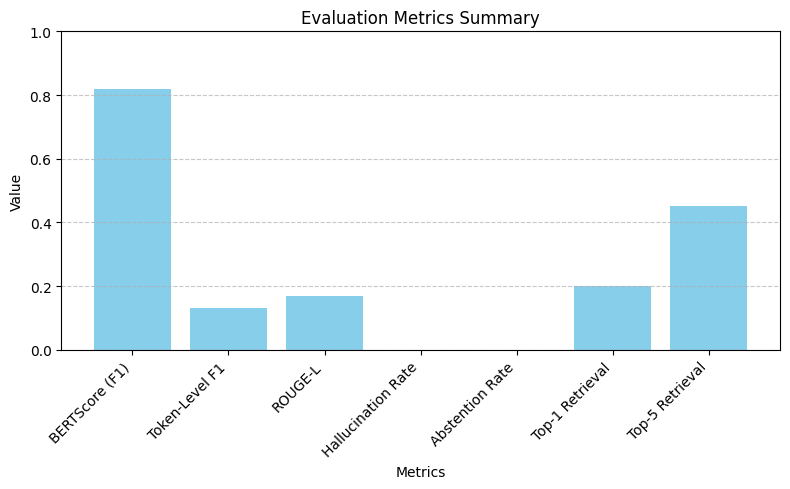

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Create a DataFrame of your evaluation metrics
data = {
    'Metric': [
        'BERTScore (F1)', 
        'Token-Level F1', 
        'ROUGE-L', 
        'Hallucination Rate', 
        'Abstention Rate',
        'Top-1 Retrieval',
        'Top-5 Retrieval'
    ],
    'Value': [
        0.82,    # BERTScore
        0.13,    # Token-Level F1
        0.17,    # ROUGE-L
        0.00,    # Hallucination Rate
        0.00,    # Abstention Rate
        0.20,    # Top-1 Retrieval
        0.45     # Top-5 Retrieval (approx. mid of 40–50%)
    ]
}

df = pd.DataFrame(data)
display(df)  # Displays a neat table in Jupyter

# 2) Plot a simple bar chart
plt.figure(figsize=(8, 5))
plt.bar(df['Metric'], df['Value'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title('Evaluation Metrics Summary')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/tmp/ipykernel_11004/2458617974.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Metric", y="Average Score", palette="Set2")


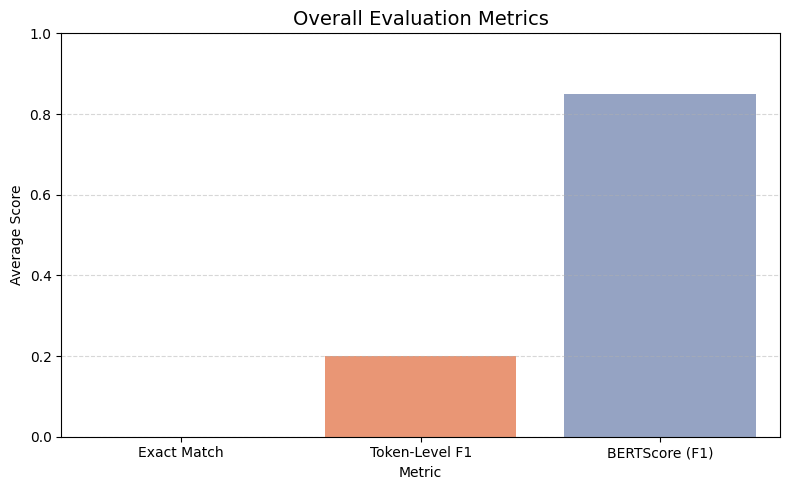

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame with overall evaluation metrics
data = {
    "Metric": ["Exact Match", "Token-Level F1", "BERTScore (F1)"],
    "Average Score": [0.00, 0.20, 0.85]
}
df = pd.DataFrame(data)

# Plot the bar chart using seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Metric", y="Average Score", palette="Set2")
plt.title("Overall Evaluation Metrics", fontsize=14)
plt.ylabel("Average Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


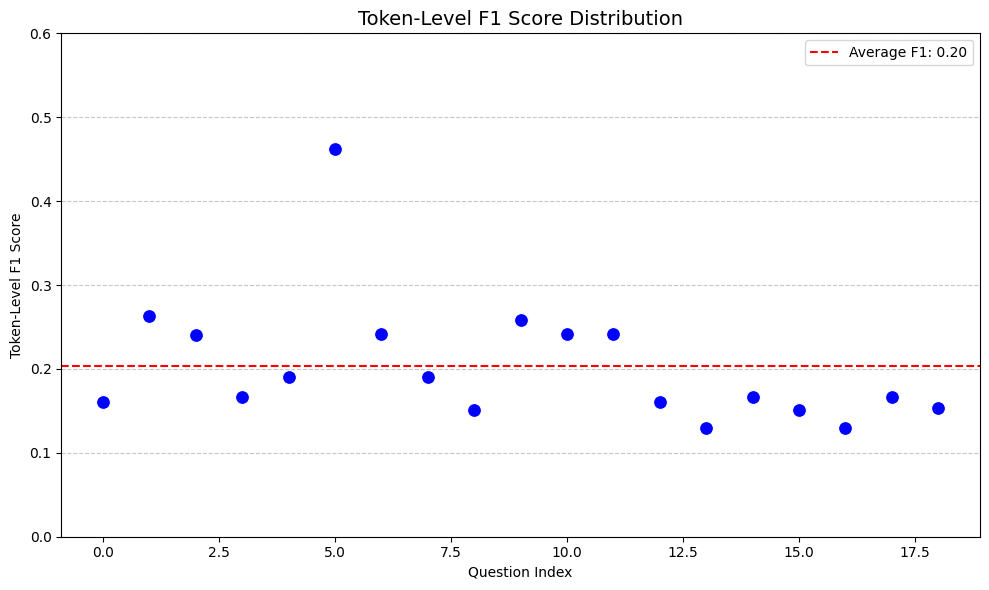

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load evaluation results (assumes "evaluation_em_f1.csv" is in your working directory)
df = pd.read_csv("evaluation_em_f1.csv")

# Create a scatter plot for Token-Level F1 Scores across questions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.index, y="f1_score", color="blue", s=100)
plt.title("Token-Level F1 Score Distribution", fontsize=14)
plt.xlabel("Question Index")
plt.ylabel("Token-Level F1 Score")
plt.ylim(0, 0.6)

# Add a horizontal line showing the average F1 score
avg_f1 = df['f1_score'].mean()
plt.axhline(y=avg_f1, color='red', linestyle='--', label=f'Average F1: {avg_f1:.2f}')
plt.legend()

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


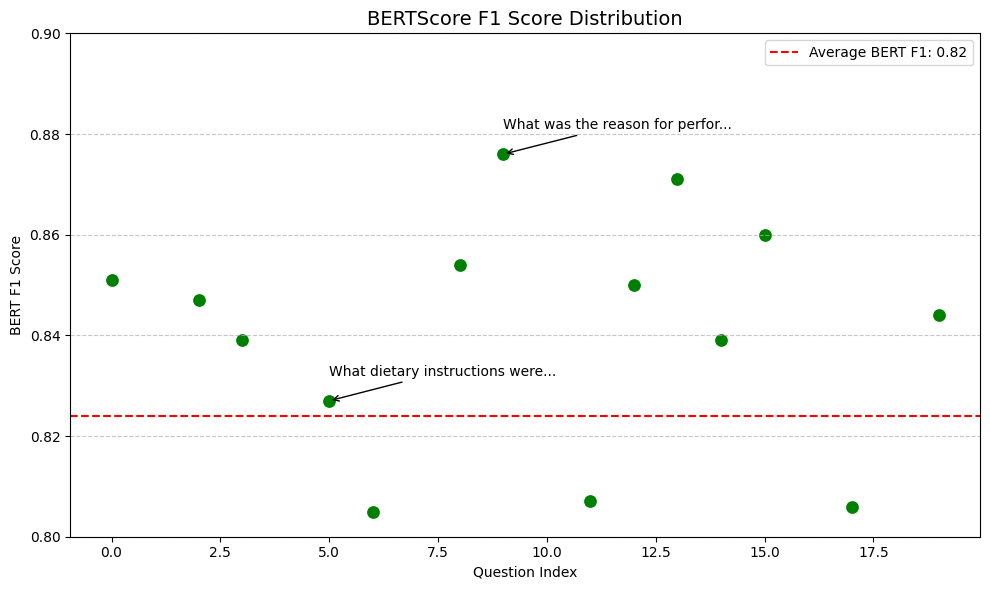

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load BERTScore evaluation results
df_bert = pd.read_csv("../conf_output/csv/evaluation_with_bertscore.csv")

# Create a scatter plot for BERT F1 scores across questions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_bert, x=df_bert.index, y="bert_f1", color="green", s=100)
plt.title("BERTScore F1 Score Distribution", fontsize=14)
plt.xlabel("Question Index")
plt.ylabel("BERT F1 Score")
plt.ylim(0.8, 0.9)

# Add a horizontal line showing the average BERT F1 score
avg_bert_f1 = df_bert['bert_f1'].mean()
plt.axhline(y=avg_bert_f1, color='red', linestyle='--', label=f'Average BERT F1: {avg_bert_f1:.2f}')
plt.legend()

# Optional: Highlight specific example questions as callouts (customize as needed)
# Example: Annotate question 5 and question 9 if they are key examples
if len(df_bert) > 9:
    plt.annotate(f"{df_bert.loc[5, 'question'][:30]}...", 
                 xy=(5, df_bert.loc[5, 'bert_f1']), 
                 xytext=(5, df_bert.loc[5, 'bert_f1']+0.005),
                 arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)
    plt.annotate(f"{df_bert.loc[9, 'question'][:30]}...", 
                 xy=(9, df_bert.loc[9, 'bert_f1']), 
                 xytext=(9, df_bert.loc[9, 'bert_f1']+0.005),
                 arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


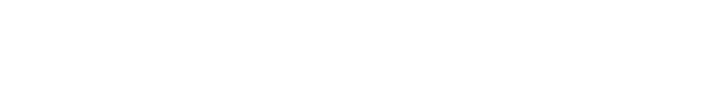

In [16]:
from graphviz import Digraph

dot = Digraph('Discussion_Future', comment='Discussion & Future Directions')
dot.attr(rankdir='TB', size='10,8', dpi='300')
dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica', fontsize='12', fillcolor='lightyellow')

# Central node
dot.node('Center', 'Discussion & Future Directions', shape='ellipse', fillcolor='gold')

# Key Insights branch
dot.node('KI', 'Key Insights', shape='box', fillcolor='lightblue')
dot.edge('Center', 'KI', constraint='true')
dot.node('KI1', 'High BERTScore validates\nrobust clinical meaning')
dot.node('KI2', 'Low Exact Match & Token F1\nacceptable due to paraphrasing')
dot.node('KI3', 'No hallucinations observed\n(system safety)')
dot.edge('KI', 'KI1')
dot.edge('KI', 'KI2')
dot.edge('KI', 'KI3')

# Areas for Improvement branch
dot.node('AI', 'Areas for Improvement', shape='box', fillcolor='lightcoral')
dot.edge('Center', 'AI', constraint='true')
dot.node('AI1', 'Enhance retrieval ranking\nand context filtering')
dot.node('AI2', 'Introduce confidence-based\nabstention for ambiguous cases')
dot.edge('AI', 'AI1')
dot.edge('AI', 'AI2')

# Future Work branch
dot.node('FW', 'Future Work', shape='box', fillcolor='lightgreen')
dot.edge('Center', 'FW', constraint='true')
dot.node('FW1', 'Scale evaluation to larger datasets')
dot.node('FW2', 'Extend architecture to additional\nclinical domains')
dot.edge('FW', 'FW1')
dot.edge('FW', 'FW2')

# Render diagram
dot.render('discussion_future_directions', format='png', cleanup=True)
dot
